In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib import patches
import seaborn as sns
import re
import string
import cellbayesassay as cba
import attila_utils

## Fitted dose-respones data

In [2]:
TI2name = pd.read_excel('../../resources/cell-based-assays/study-TI-to-name.xlsx', index_col=[0, 1])['name']
TI2name_df = pd.read_excel('../../resources/cell-based-assays/study-TI-to-name.xlsx').drop('long name', axis=1)
TI2name_df

study      TI                                     name
0   CO25360     TI1                            Valproic acid
1   CO25360     TI2                               Salbutamol
2   CO25360     TI3                               Sildenafil
3   CO25360     TI4                               Probenecid
4   CO25360     TI5                              Montelukast
5   CO25360     TI6                               Felodipine
6   CO25360     TI7                            Levetiracetam
7   CO25360     TI8                               Nifedipine
8   CO25360     TI9                                Acitretin
9   CO25360    TI10                                Dasatinib
10  CO25360    TI11                              Fluticasone
11  CO25360    TI12                             Methotrexate
12  CO25360    TI13                                      HCQ
13  CO25360    TI14                              Roflumilast
14  CO25360    TI15                              Napabucasin
15  CO25360    TI16                               Crizotinib
16  CO25360    TI17                                   C188-9
17  CO25360    TI18                                      NAP
18  CO25360    TI19                                 MTS-V-50
19  CO25360    TI20                               MTS-III-25
20  CO25360    TI21                                    TUDCA
21  CO25360    TI22                               Cysteamine
22  CO25360    TI23                               Rifampicin
23  CO25360    TI24                              Mebendazole
24  CO25360    TI25                            Pyrimethamine
25  CO25360    TI26                                 Arundine
26  CO25360    TI27                        TUDCA + fixed HCQ
27  CO25360  TI1027                        HCQ + fixed TUDCA
28  CO28151     TI1                                Amiloride
29  CO28151     TI2           Phenamil methanesulfonate salt
30  CO28151     TI3           Benzamil hydrochloride hydrate
31  CO28151     TI4  5-(N,N-Dimethyl)amiloride hydrochloride
32  CO28151     TI5         5-(N-Ethyl-N-isopropyl)amiloride
33  CO28151     TI6           5-(N,N-Hexamethylene)amiloride
34  CO28151     TI7         5-(N-Methyl-N-isobutyl)amiloride
35  CO28151     TI8                                   NS 383
36  CO28151     TI9                                 A-317567
37  CO28151    TI10                               Cilostazol
38  CO28151    TI11                                   C-DIM5
39  CO28151    TI12                                  C-DIM12
40  CO28151    TI13                              Liraglutide
41  CO28151    TI14                              Semaglutide
42  CO28151    TI15                              HCQ racemic
43  CO28153    TI16                (S)HCQ racemic, free base
44  CO28153    TI18                (R)HCQ racemic, free base
45  CO28153    TI21                           HCQ + Arundine
46  CO28153    TI22                              Belumosudil
47  CO28153    TI23                              Fasudil HCl

In [3]:
idatadf1 = cba.idatadf_from_netcdf(subdir='idatadf/', maindir='../../results/2023-09-26-cell-bayes-assays/')

In [4]:
idatas2 = cba.idatas_from_netcdf(subdir='idatas/', maindir='../../results/2024-02-14-cell-bayes/')

In [5]:
idatas3 = cba.idatas_from_netcdf(subdir='idatas/', maindir='../../results/2024-04-21-cell-bayes/')

In [6]:
idatas4 = cba.idatas_from_netcdf(subdir='idatas/', maindir='../../results/2024-04-29-cell-bayes/')

In [7]:
idatas1 = pd.DataFrame(idatadf1.to_numpy(), index=idatadf1.index, columns=pd.MultiIndex.from_product([['CO25360'], idatadf1.columns])).stack(level=[0, 1])
idatas1 = idatas1.reorder_levels([2, 0, 1, 3])
idatas1 = pd.Series(idatas1.to_numpy(), index=idatas1.index.set_names(['study', 'experiment', 'assay', 'TI']))
idatas = pd.concat([idatas1, idatas2, idatas3, idatas4])
idatas = idatas.loc[~ idatas.index.duplicated(keep='first')]
idatas

study    experiment                assay    TI    
CO25360  Aβ clearance (BV2 cells)  Aβ42 Ly  TI21      (posterior, log_likelihood, sample_stats, obse...
                                            TI22      (posterior, log_likelihood, sample_stats, obse...
                                            TI26      (posterior, log_likelihood, sample_stats, obse...
                                   Aβ42 SN  TI21      (posterior, log_likelihood, sample_stats, obse...
                                            TI22      (posterior, log_likelihood, sample_stats, obse...
                                                                            ...                        
                                   Aβ42 Ly  TI1027    (posterior, log_likelihood, sample_stats, obse...
                                   Aβ42 SN  TI1027    (posterior, log_likelihood, sample_stats, obse...
         Aβ release (H4 cells)     Aβ38     TI1027    (posterior, log_likelihood, sample_stats, obse...
             

<Axes: xlabel='study-TI', ylabel='experiment-assay'>

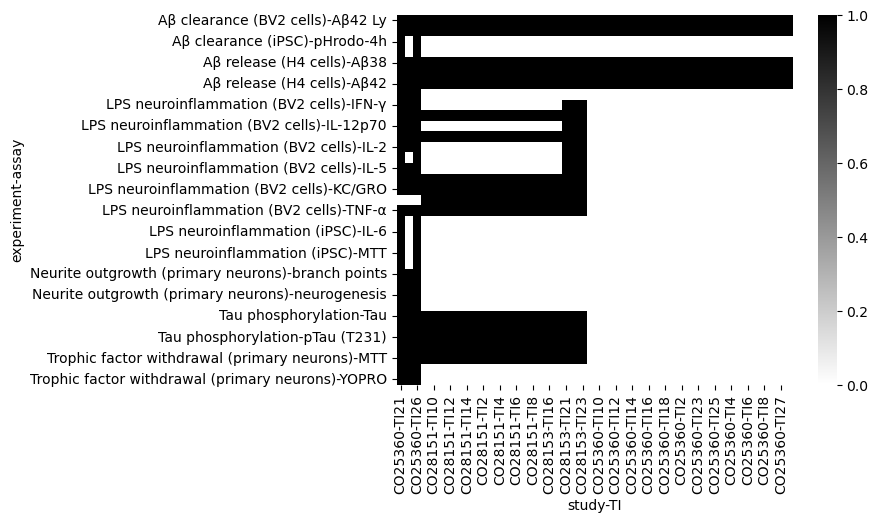

In [8]:
received = idatas.unstack(level=[0, 3]).map(lambda x: not pd.isna(x))
received
fig, ax = plt.subplots()
sns.heatmap(received, ax=ax, cmap='binary')

## Posteriors and Bayes factors

In [35]:
fpathl = [
    '../../results/2023-09-26-cell-bayes-assays/H102_posteriors.csv',
    #'../../results/2024-02-14-cell-bayes/H102_posteriors.csv',
    #'../../results/2024-01-21-cell-bayes-assays-dim/H102_posteriors.csv'
]
l = [pd.read_csv(fpath, index_col=[0, 1], header=[0, 1]) for fpath in fpathl]
H102_posteriors1 = pd.concat([l[0]], axis=1)
#H102_posteriors1 = pd.concat([l[0], l[1].drop('Arundine', level=0, axis=1)], axis=1)
H102_posteriors1 = H102_posteriors1.stack(level=0)
H102_posteriors1['name'] = H102_posteriors1.index.get_level_values(2)
name2TI = {
    'TUDCA': ('CO25360', 'TI21'),
    'Cysteamine': ('CO25360', 'TI22'),
    'Arundine': ('CO25360', 'TI26'),
    'C-DIM5': ('CO28151', 'TI11'),
    'C-DIM12': ('CO28151', 'TI12'),
}
l = [H102_posteriors1.name.apply(lambda x: name2TI[x][i]).to_frame(c) for i, c in zip(range(2), ['study', 'TI'])]
ixdf = pd.concat([l[0], H102_posteriors1.index.to_frame().iloc[:, :-1].rename({0: 'experiment', 1:'assay'}, axis=1), l[1]], axis=1)
H102_posteriors1 = pd.DataFrame(H102_posteriors1.to_numpy(), index=pd.MultiIndex.from_frame(ixdf), columns=H102_posteriors1.columns.to_list())
H102_posteriors1

H1  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    0.879   
                                                            TI22      0.0   
                                                            TI21  0.99275   
                                                    Aβ42 SN TI26    0.373   
                                                            TI22    0.002   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.00075   
                                                            TI21  0.00025   
                                                    YOPRO   TI26   0.0005   
                                                            TI22      0.0   
                                                            TI21  0.00875   

                                                                       H0  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26     0.12   
                                                            TI22      0.0   
                                                            TI21  0.00725   
                                                    Aβ42 SN TI26   0.6255   
                                                            TI22  0.18175   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.98275   
                                                            TI21  0.93475   
                                                    YOPRO   TI26    0.977   
                                                            TI22  0.95175   
                                                            TI21  0.97275   

                                                                       H2  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    0.001   
                                                            TI22      1.0   
                                                            TI21      0.0   
                                                    Aβ42 SN TI26   0.0015   
                                                            TI22  0.81625   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22   0.0165   
                                                            TI21    0.065   
                                                    YOPRO   TI26   0.0225   
                                                            TI22  0.04825   
                                                            TI21   0.0185   

                                                                        name  
study   experiment                                  assay   TI                
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    Arundine  
                                                            TI22  Cysteamine  
                                                            TI21       TUDCA  
                                                    Aβ42 SN TI26    Arundine  
                                                            TI22  Cysteamine  
...                                                                      ...  
        Trophic factor withdrawal (primary neurons) PI      TI22  Cysteamine  
                                                            TI21       TUDCA  
                                                    YOPRO   TI26    Arundine  
                                                            TI22  Cysteamine  
                                                            TI21       TUDCA  

[91 rows x 4 columns]

In [36]:
H102_posteriors2 = pd.read_csv('../../results/2024-02-14-cell-bayes/H102_posteriors.csv', index_col=list(range(4)))
H102_posteriors3 = pd.read_csv('../../results/2024-04-21-cell-bayes/H102_posteriors.csv', index_col=list(range(4)))
H102_posteriors4 = pd.read_csv('../../results/2024-04-29-cell-bayes/H102_posteriors.csv', index_col=list(range(4)))
H102_posteriors = pd.concat([H102_posteriors1, H102_posteriors2, H102_posteriors3, H102_posteriors4], axis=0)
H102_posteriors = H102_posteriors.loc[~ H102_posteriors.index.duplicated(keep='first')]
H102_posteriors

H1       H0       H2  \
study   experiment               assay   TI                                  
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI26      0.879     0.12    0.001   
                                         TI22        0.0      0.0      1.0   
                                         TI21    0.99275  0.00725      0.0   
                                 Aβ42 SN TI26      0.373   0.6255   0.0015   
                                         TI22      0.002  0.18175  0.81625   
...                                                  ...      ...      ...   
        Aβ release (H4 cells)    Aβ42    TI23    0.08125  0.91425   0.0045   
                                         TI24    0.09825  0.89575    0.006   
                                         TI25    0.00625   0.9645  0.02925   
                                         TI27     0.0245  0.90875  0.06675   
                                         TI1027   0.0245  0.90875  0.06675   

                                                              name  
study   experiment               assay   TI                         
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI26             Arundine  
                                         TI22           Cysteamine  
                                         TI21                TUDCA  
                                 Aβ42 SN TI26             Arundine  
                                         TI22           Cysteamine  
...                                                            ...  
        Aβ release (H4 cells)    Aβ42    TI23           Rifampicin  
                                         TI24          Mebendazole  
                                         TI25        Pyrimethamine  
                                         TI27    TUDCA + fixed HCQ  
                                         TI1027  HCQ + fixed TUDCA  

[554 rows x 4 columns]

In [37]:
BF10 = cba.BF10_from_H102_posteriors_long(cba.pseudocount_to_H102_posteriors(H102_posteriors), merge_H0_H2=True)
BF10 = pd. concat([BF10, idatas.apply(lambda x: not pd.isna(x)).to_frame('received')], axis=1)
vmin = BF10['2 log BF'].min()
vmax = BF10['2 log BF'].max()
BF10['2 log BF'] = BF10.apply(lambda r: -1000 if (r.loc['received'] and pd.isna(r.loc['2 log BF'])) else r.loc['2 log BF'], axis=1)
ixdf = BF10.index.to_frame()
ixdf['name'] = ixdf.apply(lambda r: TI2name.loc[(r.loc['study'], r.loc['TI'])], axis=1)
BF10 = pd.DataFrame(BF10.to_numpy(), index=pd.MultiIndex.from_frame(ixdf), columns=BF10.columns)
BF10

Study  \
study   experiment                          assay        TI     name                         
CO25360 Aβ clearance (BV2 cells)            Aβ42 Ly      TI26   Arundine           CO25360   
                                                         TI22   Cysteamine         CO25360   
                                                         TI21   TUDCA              CO25360   
                                            Aβ42 SN      TI26   Arundine           CO25360   
                                                         TI22   Cysteamine         CO25360   
...                                                                                    ...   
        Aβ release (H4 cells)               Aβ42         TI27   TUDCA + fixed HCQ  CO25360   
                                                         TI1027 HCQ + fixed TUDCA  CO25360   
        LPS neuroinflammation (BV2 cells)   IFN-γ        TI26   Arundine               NaN   
        Neurite outgrowth (primary neurons) neurogenesis TI22   Cysteamine             NaN   
        Tau phosphorylation                 pT/T ratio   TI26   Arundine               NaN   

                                                                                                 Experiment  \
study   experiment                          assay        TI     name                                          
CO25360 Aβ clearance (BV2 cells)            Aβ42 Ly      TI26   Arundine           Aβ clearance (BV2 cells)   
                                                         TI22   Cysteamine         Aβ clearance (BV2 cells)   
                                                         TI21   TUDCA              Aβ clearance (BV2 cells)   
                                            Aβ42 SN      TI26   Arundine           Aβ clearance (BV2 cells)   
                                                         TI22   Cysteamine         Aβ clearance (BV2 cells)   
...                                                                                                     ...   
        Aβ release (H4 cells)               Aβ42         TI27   TUDCA + fixed HCQ     Aβ release (H4 cells)   
                                                         TI1027 HCQ + fixed TUDCA     Aβ release (H4 cells)   
        LPS neuroinflammation (BV2 cells)   IFN-γ        TI26   Arundine                                NaN   
        Neurite outgrowth (primary neurons) neurogenesis TI22   Cysteamine                              NaN   
        Tau phosphorylation                 pT/T ratio   TI26   Arundine                                NaN   

                                                                                     Assay  \
study   experiment                          assay        TI     name                         
CO25360 Aβ clearance (BV2 cells)            Aβ42 Ly      TI26   Arundine           Aβ42 Ly   
                                                         TI22   Cysteamine         Aβ42 Ly   
                                                         TI21   TUDCA              Aβ42 Ly   
                                            Aβ42 SN      TI26   Arundine           Aβ42 SN   
                                                         TI22   Cysteamine         Aβ42 SN   
...                                                                                    ...   
        Aβ release (H4 cells)               Aβ42         TI27   TUDCA + fixed HCQ     Aβ42   
                                                         TI1027 HCQ + fixed TUDCA     Aβ42   
        LPS neuroinflammation (BV2 cells)   IFN-γ        TI26   Arundine               NaN   
        Neurite outgrowth (primary neurons) neurogenesis TI22   Cysteamine             NaN   
        Tau phosphorylation                 pT/T ratio   TI26   Arundine               NaN   

                                                                                       TI  \
study   experiment                          assay        TI     name                        
CO25360 A

In [38]:
BF10_wide = BF10['2 log BF'].unstack(level=[0, 3, 4]).astype('float64')
BF10_wide

study                                                            CO25360  \
TI                                                                  TI26   
name                                                            Arundine   
experiment                                  assay                          
Aβ clearance (BV2 cells)                    Aβ42 Ly             3.965989   
                                            Aβ42 SN            -1.038736   
Aβ clearance (iPSC)                         pHrodo-4h         -17.974394   
                                            supernatant       -10.394984   
Aβ release (H4 cells)                       Aβ38               -5.259440   
                                            Aβ40               -5.181341   
                                            Aβ42               -5.032100   
Aβ toxicity (primary neurons)               MTT               -16.587599   
LPS neuroinflammation (BV2 cells)           IFN-γ           -1000.000000   
                                            IL-10              -3.869060   
                                            IL-12p70            1.984175   
                                            IL-1β             -13.813510   
                                            IL-2               -7.684018   
                                            IL-4               16.588099   
                                            IL-5                3.257524   
                                            IL-6               -5.365465   
                                            KC/GRO             -1.090217   
                                            MTT                      NaN   
                                            TNF-α              -4.720614   
LPS neuroinflammation (iPSC)                IL-1β              10.305578   
                                            IL-6               12.841493   
                                            IL-8                8.738896   
                                            MTT               -12.425212   
                                            TNF-α               8.085085   
Neurite outgrowth (primary neurons)         branch points     -17.974394   
                                            longest neurite   -13.813510   
                                            neurogenesis      -15.200805   
                                            Σ neurite area    -17.974394   
Tau phosphorylation                         Tau                -1.951358   
                                            pT/T ratio      -1000.000000   
                                            pTau (T231)        -6.724272   
Trophic factor withdrawal (primary neurons) LDH               -17.974394   
                                            MTT               -17.974394   
                                            PI                 -5.847430   
                                            YOPRO             -15.200805   

study                                                                     \
TI                                                                  TI22   
name                                                          Cysteamine   
experiment                                  assay                          
Aβ clearance (BV2 cells)                    Aβ42 Ly           -17.974644   
                                            Aβ42 SN           -12.425212   
Aβ clearance (iPSC)                         pHrodo-4h                NaN   
                                            supernatant              NaN   
Aβ release (H4 cells)                       Aβ38               -4.018215   
                                            Aβ40               -2.377305   
                                            Aβ42               -2.975935   
Aβ toxicity (primary neurons)               MTT                -3.331672   
LPS neuroinflammation (BV2 cells)           IFN-γ             -17.974394   
                                            IL-

['named-figure/cell-based-assays-summary.png',
 'named-figure/cell-based-assays-summary.pdf']

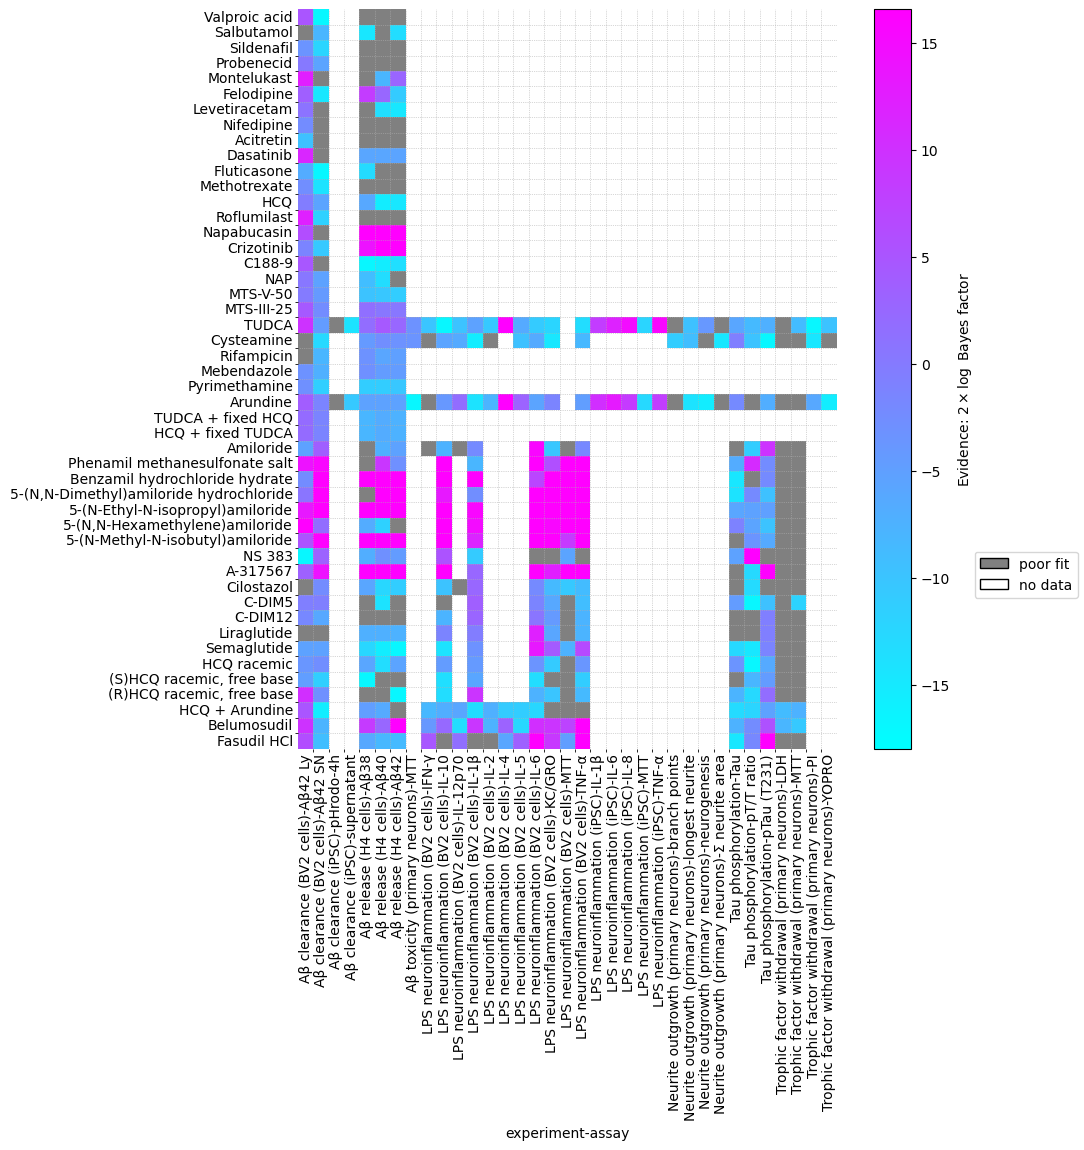

In [39]:
def my_heatmap(data=BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).transpose(), vmin=vmin, vmax=vmax):
    cool = matplotlib.colormaps['cool']
    cool_colors = cool(np.linspace(0, 1, 127))
    gray_colors = np.array([[0.5, 0.5, 0.5, 1]])
    my_cmap = ListedColormap(np.concatenate([gray_colors, cool_colors], axis=0))    
    fig, ax = plt.subplots(1, 1, figsize=(9.6, 9.6))
    ax = sns.heatmap(data, ax=ax, cmap=my_cmap, vmin=vmin, vmax=vmax, square=True, cbar=False)
    ax.set_ylabel('')
    for set_ticks, get_ticks in zip([ax.set_xticks, ax.set_yticks], [ax.get_xticks, ax.get_yticks]):
        set_ticks(np.arange(1, stop=get_ticks()[-1]), minor=True)
    ax.tick_params(which='major', length=0)
    cbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax, clip=False), cmap='cool'), ax=ax, location='right', label=r'Evidence: $2 \times \log$ Bayes factor')
    ax.grid(axis='both', which='minor', linewidth=0.5, linestyle='dotted')
    rectangles = [patches.Rectangle((0, 0), 10, 10, facecolor=c, edgecolor='k') for c in ['gray', 'white']]
    fig.legend(rectangles, ['poor fit', 'no data'], loc='center right')
    return((fig, ax))

fig, ax = my_heatmap(BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).transpose().droplevel([0, 1], axis=0))
attila_utils.savefig(fig, 'cell-based-assays-summary')

In [40]:
fpath = '../../results/2024-04-09-qps-results-summary/cell-based-assays-Bayes-factors.xlsx'
BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).transpose().map(lambda x: 'no data' if pd.isna(x) else x).map(lambda x: 'poor fit' if x == -1000 else x).to_excel(fpath)

## Raw data

In [41]:
fpath = '../../resources/cell-based-assays/data-format-specification_NIA_all-CO28151_CO28153.xlsx'
data = pd.read_excel(fpath, sheet_name='Sheet1')
data

Study                         Experiment  Assay  Batch  Plate   TI  \
0     CO28153  LPS neuroinflammation (BV2 cells)  IFN-γ      3      1  LPS   
1     CO28153  LPS neuroinflammation (BV2 cells)  IFN-γ      3      1  LPS   
2     CO28153  LPS neuroinflammation (BV2 cells)  IFN-γ      3      1  LPS   
3     CO28153  LPS neuroinflammation (BV2 cells)  IFN-γ      3      1  LPS   
4     CO28153  LPS neuroinflammation (BV2 cells)  IFN-γ      3      1  LPS   
...       ...                                ...    ...    ...    ...  ...   
9253  CO28153              Aβ release (H4 cells)   Aβ38      2      3   RI   
9254  CO28153              Aβ release (H4 cells)   Aβ38      2      3   RI   
9255  CO28153              Aβ release (H4 cells)   Aβ38      2      3   RI   
9256  CO28153              Aβ release (H4 cells)   Aβ38      2      3   RI   
9257  CO28153              Aβ release (H4 cells)   Aβ38      2      3   RI   

     Conc  Activity  
0     NaN  0.043041  
1     NaN  0.159173  
2     NaN  0.029069  
3     NaN  0.134404  
4     NaN  0.106824  
...   ...       ...  
9253  NaN  735.0628  
9254  NaN  641.8745  
9255  NaN  660.8184  
9256  NaN  696.0789  
9257  NaN  579.1129  

[9258 rows x 8 columns]

In [42]:
data1 = data[['Study', 'Experiment', 'Assay', 'TI']]
data1 = data1.loc[data1.TI.apply(lambda x: bool(re.match('TI[0-9]{1,2}.*', x)))]
a, exper_assay_raw = [data1.apply(lambda r: tuple(r.to_list()[i:j]), axis=1).unique() for i, j in [[0, 4], [1, 3]]]
s, s1 = [pd.Series(x) for x in [a, exper_assay_raw]]
available_new, available_new1 = [x.apply(lambda t: pd.Series(t)) for x in [s, s1]]
available_new = available_new.rename({0: 'Study', 1: 'Experiment', 2: 'Assay', 3: 'TI'}, axis=1)
available_new1 = available_new1.rename({0: 'Experiment', 1: 'Assay'}, axis=1)
available_new['Available'] = 2
available_new = available_new.set_index(['Study', 'Experiment', 'Assay', 'TI'])
available_new1

Experiment        Assay
0             LPS neuroinflammation (BV2 cells)        IFN-γ
1             LPS neuroinflammation (BV2 cells)        IL-10
2             LPS neuroinflammation (BV2 cells)     IL-12p70
3             LPS neuroinflammation (BV2 cells)        IL-1β
4             LPS neuroinflammation (BV2 cells)         IL-6
5             LPS neuroinflammation (BV2 cells)       KC/GRO
6             LPS neuroinflammation (BV2 cells)        TNF-α
7                           Tau phosphorylation   pT/T ratio
8                           Tau phosphorylation  pTau (T231)
9                           Tau phosphorylation          Tau
10  Trophic factor withdrawal (primary neurons)          LDH
11  Trophic factor withdrawal (primary neurons)          MTT
12            LPS neuroinflammation (BV2 cells)          MTT
13            LPS neuroinflammation (BV2 cells)         IL-2
14            LPS neuroinflammation (BV2 cells)         IL-4
15            LPS neuroinflammation (BV2 cells)         IL-5
16                        Aβ release (H4 cells)         Aβ38
17                        Aβ release (H4 cells)         Aβ40
18                        Aβ release (H4 cells)         Aβ42
19                     Aβ clearance (BV2 cells)      Aβ42 Ly
20                     Aβ clearance (BV2 cells)      Aβ42 SN

In [43]:
available_new.iloc[267:269]

Available
Study   Experiment            Assay TI             
CO28151 Aβ release (H4 cells) Aβ38  TI12          2
                                    TI13          2

In [44]:
exper_assay_pretty = BF10_wide.index.to_frame()[['experiment', 'assay']].apply(lambda r: tuple(r.to_list()), axis=1).unique()
S_pretty = set(exper_assay_pretty)
S_raw = set(exper_assay_raw)
print('Assays missing from the new dataset:')
print(S_pretty.difference(S_raw))
print('Assays missing from the old dataset:')
S_raw.difference(S_pretty)

Assays missing from the new dataset:
{('Aβ toxicity (primary neurons)', 'MTT'), ('LPS neuroinflammation (iPSC)', 'TNF-α'), ('Aβ clearance (iPSC)', 'pHrodo-4h'), ('Trophic factor withdrawal (primary neurons)', 'YOPRO'), ('Neurite outgrowth (primary neurons)', 'Σ neurite area'), ('LPS neuroinflammation (iPSC)', 'IL-1β'), ('Neurite outgrowth (primary neurons)', 'neurogenesis'), ('Neurite outgrowth (primary neurons)', 'longest neurite'), ('Trophic factor withdrawal (primary neurons)', 'PI'), ('LPS neuroinflammation (iPSC)', 'IL-8'), ('LPS neuroinflammation (iPSC)', 'MTT'), ('Aβ clearance (iPSC)', 'supernatant'), ('Neurite outgrowth (primary neurons)', 'branch points'), ('LPS neuroinflammation (iPSC)', 'IL-6')}
Assays missing from the old dataset:


set()

In [45]:
all_exper_assay = pd.DataFrame(np.array([[t[i] for t in list(S_pretty.union(S_raw))] for i in range(2)]).transpose(), columns=['experiment', 'assay'])
all_exper_assay = all_exper_assay.sort_values(['experiment', 'assay'])
all_exper_assay

experiment            assay
4                      Aβ clearance (BV2 cells)          Aβ42 Ly
7                      Aβ clearance (BV2 cells)          Aβ42 SN
19                          Aβ clearance (iPSC)        pHrodo-4h
29                          Aβ clearance (iPSC)      supernatant
34                        Aβ release (H4 cells)             Aβ38
15                        Aβ release (H4 cells)             Aβ40
18                        Aβ release (H4 cells)             Aβ42
6                 Aβ toxicity (primary neurons)              MTT
30            LPS neuroinflammation (BV2 cells)            IFN-γ
2             LPS neuroinflammation (BV2 cells)            IL-10
12            LPS neuroinflammation (BV2 cells)         IL-12p70
17            LPS neuroinflammation (BV2 cells)            IL-1β
16            LPS neuroinflammation (BV2 cells)             IL-2
21            LPS neuroinflammation (BV2 cells)             IL-4
0             LPS neuroinflammation (BV2 cells)             IL-5
22            LPS neuroinflammation (BV2 cells)             IL-6
13            LPS neuroinflammation (BV2 cells)           KC/GRO
25            LPS neuroinflammation (BV2 cells)              MTT
31            LPS neuroinflammation (BV2 cells)            TNF-α
26                 LPS neuroinflammation (iPSC)            IL-1β
33                 LPS neuroinflammation (iPSC)             IL-6
28                 LPS neuroinflammation (iPSC)             IL-8
5                  LPS neuroinflammation (iPSC)              MTT
8                  LPS neuroinflammation (iPSC)            TNF-α
32          Neurite outgrowth (primary neurons)    branch points
3           Neurite outgrowth (primary neurons)  longest neurite
20          Neurite outgrowth (primary neurons)     neurogenesis
10          Neurite outgrowth (primary neurons)   Σ neurite area
27                          Tau phosphorylation              Tau
24                          Tau phosphorylation       pT/T ratio
11                          Tau phosphorylation      pTau (T231)
1   Trophic factor withdrawal (primary neurons)              LDH
23  Trophic factor withdrawal (primary neurons)              MTT
14  Trophic factor withdrawal (primary neurons)               PI
9   Trophic factor withdrawal (primary neurons)            YOPRO

['named-figure/cell-based-assays-summary-all.png',
 'named-figure/cell-based-assays-summary-all.pdf']

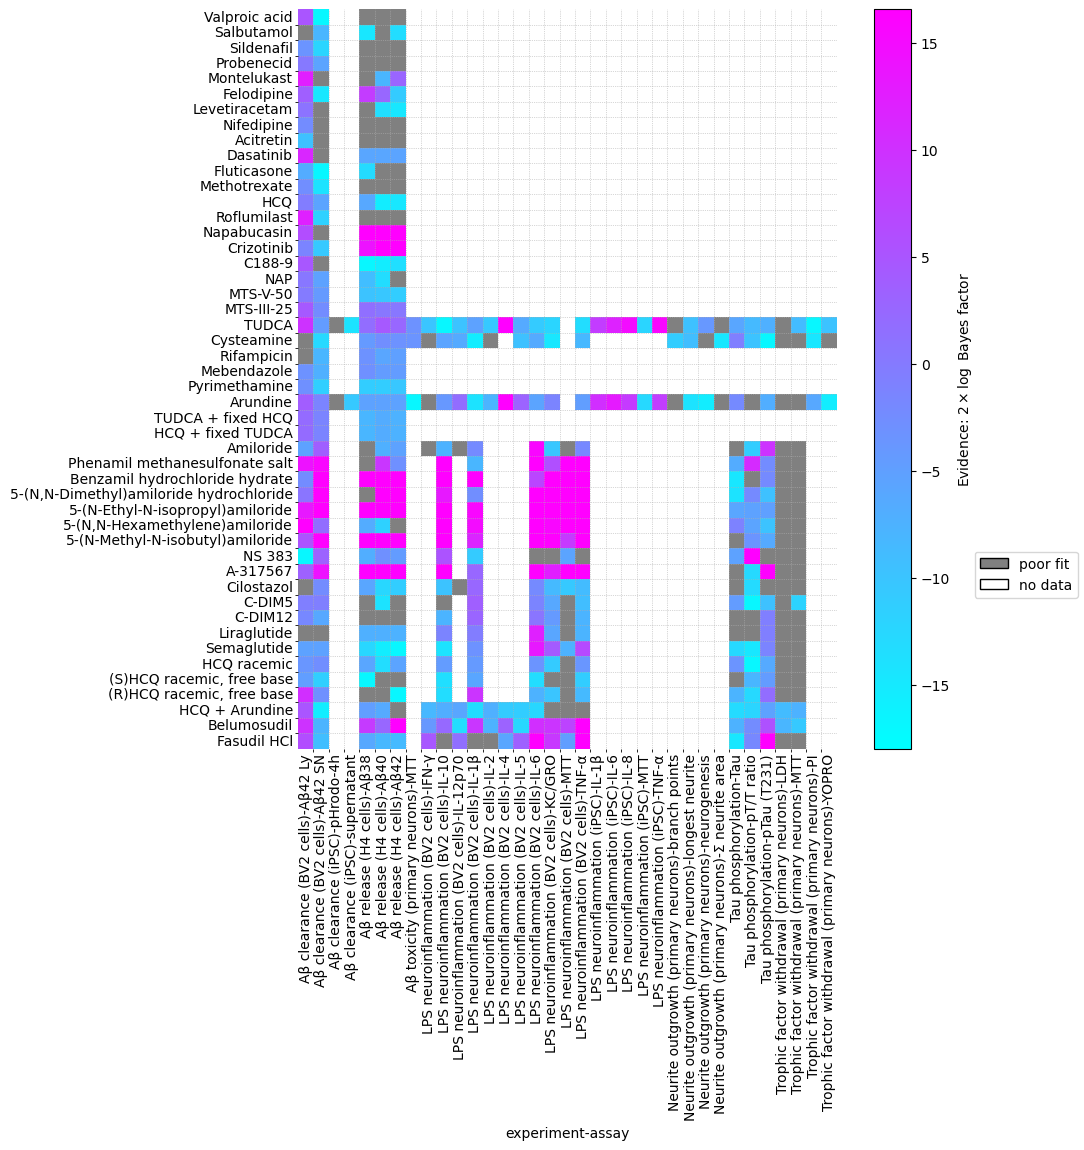

In [46]:
fig, ax = my_heatmap(BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).reindex(pd.MultiIndex.from_frame(all_exper_assay), axis=0).transpose().droplevel([0, 1], axis=0))
attila_utils.savefig(fig, 'cell-based-assays-summary-all')

In [47]:
available_old = pd.DataFrame({'Available': 1}, index=idatas.index)
available_old

Available
study   experiment               assay   TI               
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI21            1
                                         TI22            1
                                         TI26            1
                                 Aβ42 SN TI21            1
                                         TI22            1
...                                                    ...
                                 Aβ42 Ly TI1027          1
                                 Aβ42 SN TI1027          1
        Aβ release (H4 cells)    Aβ38    TI1027          1
                                 Aβ40    TI1027          1
                                 Aβ42    TI1027          1

[554 rows x 1 columns]

['named-figure/presence-in-old-new-datasets.png',
 'named-figure/presence-in-old-new-datasets.pdf']

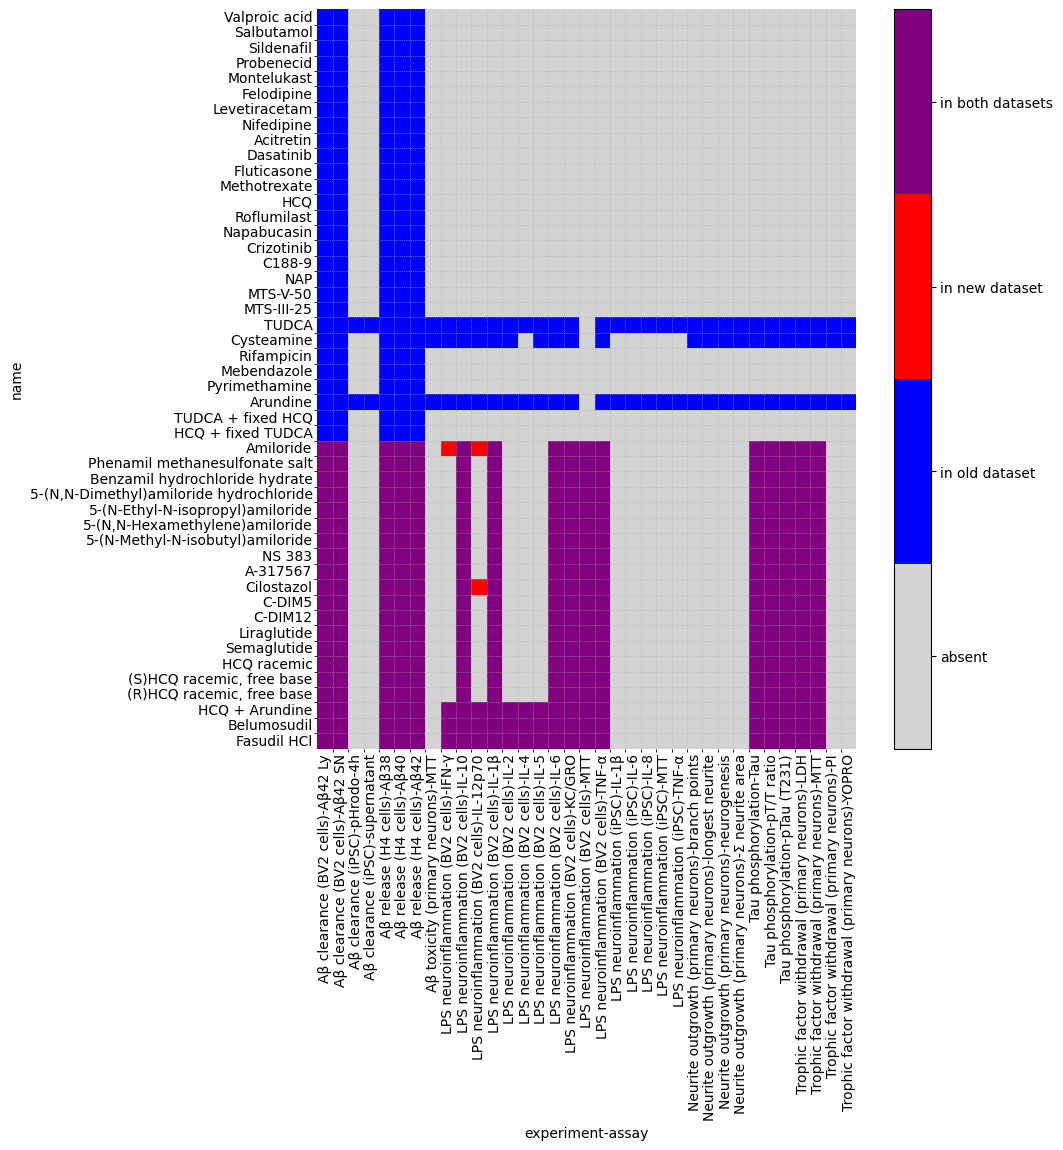

In [48]:
def expand_available_matrix(available, TI2name_df=TI2name_df, all_exper_assay=all_exper_assay):
    df = available['Available'].unstack(level=[1, 2])
    df = df.reindex(pd.MultiIndex.from_frame(TI2name_df.drop('name', axis=1)), axis=0)
    df = df.reindex(pd.MultiIndex.from_frame(all_exper_assay), axis=1)
    df = df.fillna(0)
    return(df)

def my_heatmap_2(data):
    mcmap = matplotlib.colormaps['brg']
    mcmap_colors = mcmap(np.linspace(0, 1, 3))
    gray_colors = np.array([[0.5, 0.5, 0.5, 1]])
    my_cmap = ListedColormap(['lightgray', 'blue', 'red', 'purple'])
    fig, ax = plt.subplots(1, 1, figsize=(9.6, 9.6))
    ax = sns.heatmap(data, ax=ax, cmap=my_cmap, square=True, cbar=False)
    for set_ticks, get_ticks in zip([ax.set_xticks, ax.set_yticks], [ax.get_xticks, ax.get_yticks]):
        set_ticks(np.arange(1, stop=get_ticks()[-1]), minor=True)
    ax.tick_params(which='major', length=0)
    cbar = fig.colorbar(cm.ScalarMappable(cmap=my_cmap), ax=ax, location='right')
    cbar.ax.set_yticks(np.linspace(0.125, 0.875, 4))
    cbar.ax.set_yticklabels(['absent', 'in old dataset', 'in new dataset', 'in both datasets'])
    ax.grid(axis='both', which='minor', linewidth=0.5, linestyle='dotted')
    return((fig, ax))

available_wide = expand_available_matrix(available_old) + expand_available_matrix(available_new)
fig, ax = my_heatmap_2(pd.DataFrame(available_wide.to_numpy(), index=TI2name_df['name'], columns=available_wide.columns))
attila_utils.savefig(fig, 'presence-in-old-new-datasets')

In [49]:
fpath = '../../results/2024-04-09-qps-results-summary/presence-in-old-new-datasets.xlsx'
df = pd.DataFrame(available_wide.to_numpy(), index=pd.MultiIndex.from_frame(TI2name_df), columns=available_wide.columns)
df = df.map(lambda x: {0: 'absent', 1: 'in old dataset', 2: 'in new dataset', 3: 'in both datasets'}[x])
df.to_excel(fpath)

## Aggregation

['named-figure/cell-based-assays-summary-all-agg.png',
 'named-figure/cell-based-assays-summary-all-agg.pdf']

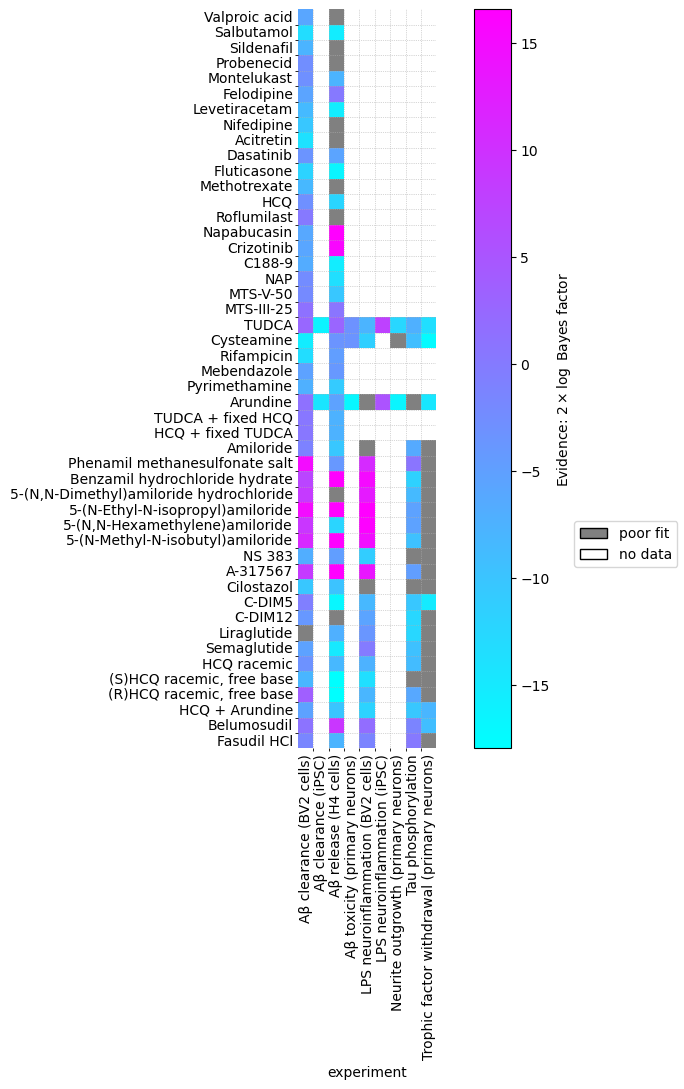

In [50]:
BF10_agg = BF10_wide.groupby('experiment', sort=False).mean().transpose()
BF10_agg = pd.DataFrame(BF10_agg.to_numpy(), index=BF10_agg.index.get_level_values('name'), columns=BF10_agg.columns)
BF10_agg = BF10_agg.loc[TI2name]
fig, ax = my_heatmap(BF10_agg)
ax.set_yticks(np.arange(BF10_agg.shape[0]) + 0.5)
ax.set_yticklabels(BF10_agg.index)
attila_utils.savefig(fig, 'cell-based-assays-summary-all-agg')

['named-figure/exper-barplot-Aβ-clearance-BV2-cells.png',
 'named-figure/exper-barplot-Aβ-clearance-BV2-cells.pdf']

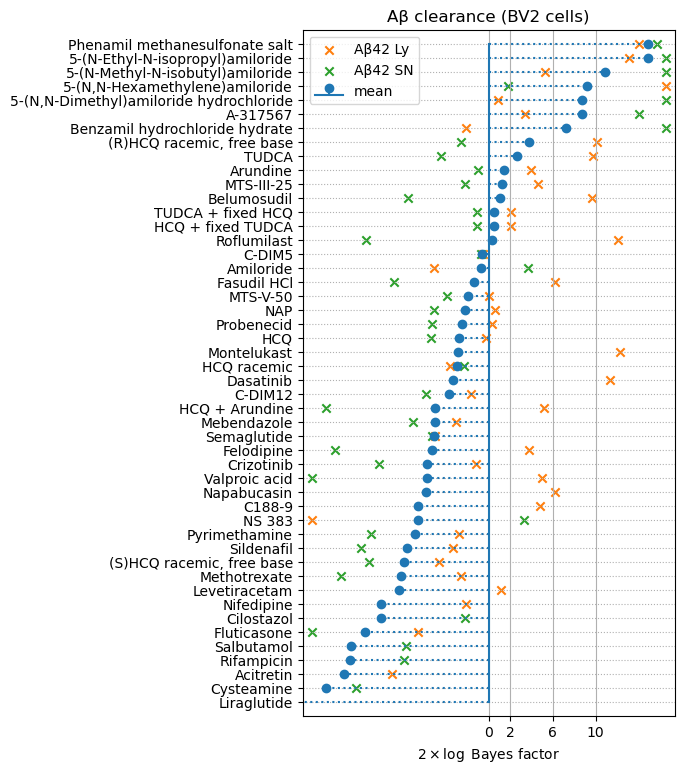

In [51]:
def exper_barplot(experiment='Aβ clearance (BV2 cells)', BF10_wide=BF10_wide, draw_legend=True):
    BF10_agg = BF10_wide.groupby('experiment').mean().transpose()
    df = BF10_wide.xs(experiment, axis=0, level='experiment').transpose()
    df = df.dropna(how='all')
    letters = string.ascii_lowercase[:df.shape[1]]
    assays2letters = dict(zip(df.columns, letters))
    letters2assays = dict(zip(letters, df.columns))
    df = df.rename(assays2letters, axis=1)
    df['average'] = df.mean(axis=1)
    df = df.sort_values('average', ascending=True)
    df_max = df.max().max()
    lim = abs(1.05 * df_max)
    df['name'] = df.index.to_frame()[['name']]
    ys = np.arange(df.shape[0])
    fig, ax = plt.subplots(figsize=(4.8, (len(df) + 1) / 5.5))
    ax.stem(df['average'], orientation='horizontal', label='mean', linefmt=':', basefmt='C0-')
    #ax.scatter(y=ys, x=df['average'], marker='o', label='mean')
    #ax.barh(y=ys, width='average', data=df)
    #for c, color in zip(letters, ['C' + str(i + 1) for i in range(len(letters))]):
    my_colors = ['C' + str(i + 1) for i in range(len(letters))]
    my_markers = 10 * ['x'] + 10 * ['+']
    for c, color, marker in zip(letters, my_colors, my_markers):
        s = df[c]
        xs = s.to_list()
        ax.scatter(x=xs, y=ys, marker=marker, c=color, label=letters2assays[c])
        for x, y in zip(xs, ys):
            if x > - lim:
                #ax.text(x=x, y=y, s=c, verticalalignment='center', horizontalalignment='center')
                pass
    ax.set_xlim(- lim, lim)
    ax.set_ylim(- 1, df.shape[0])
    ax.set_title(experiment)
    ax.set_yticks(ys)
    ax.set_yticklabels(df.index.to_frame()['name'].to_list())
    xticks_major = [0, 2, 6, 10]
    xticks_minor = [-2, 1, 4, 8, 12]
    ax.set_xticks(xticks_major, minor=False)
    xticklabels_minor = len(xticks_minor) * ['']
    ax.grid(axis='x')
    ax.grid(axis='y', linestyle='dotted')
    if draw_legend:
        ax.legend()
    ax.set_xlabel(r'$2 \times \log$ Bayes factor')
    return((fig, ax))

experiment = 'Aβ clearance (BV2 cells)'
fig, ax = exper_barplot(experiment)
attila_utils.savefig(fig, 'exper-barplot-' + re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/exper-barplot-Aβ-clearance-iPSC.png',
 'named-figure/exper-barplot-Aβ-clearance-iPSC.pdf']

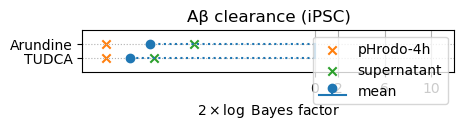

In [52]:
experiment = 'Aβ clearance (iPSC)'
fig, ax = exper_barplot(experiment)
ax.set_xlim(-20, 12)
attila_utils.savefig(fig, 'exper-barplot-' + re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/exper-barplot-Aβ-release-H4-cells.png',
 'named-figure/exper-barplot-Aβ-release-H4-cells.pdf']

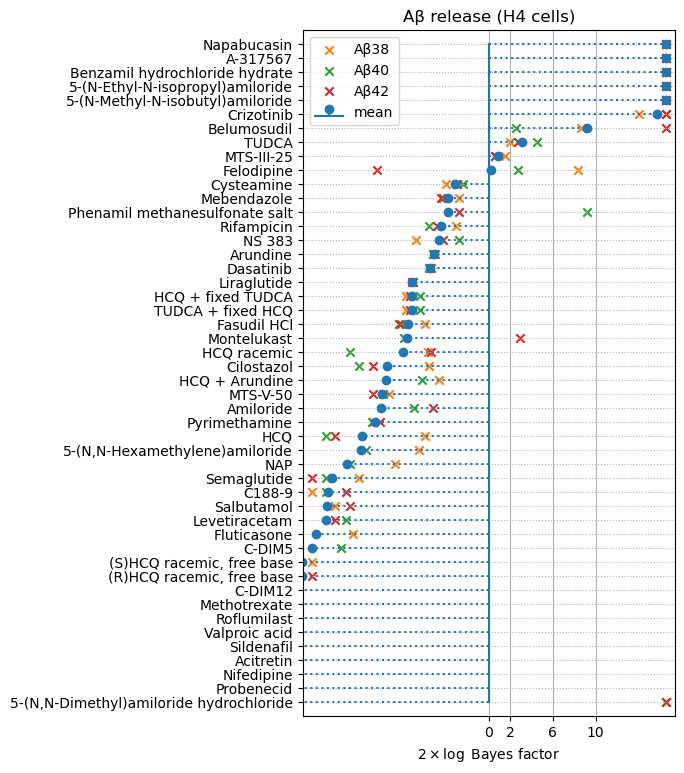

In [53]:
experiment = 'Aβ release (H4 cells)'
fig, ax = exper_barplot(experiment)
attila_utils.savefig(fig, 'exper-barplot-' + re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/exper-barplot-Aβ-toxicity-primary-neurons.png',
 'named-figure/exper-barplot-Aβ-toxicity-primary-neurons.pdf']

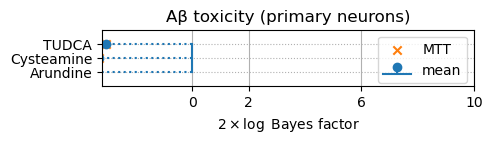

In [54]:
experiment = 'Aβ toxicity (primary neurons)'
fig, ax = exper_barplot(experiment)
attila_utils.savefig(fig, 'exper-barplot-' + re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/exper-barplot-LPS-neuroinflammation-BV2-cells.png',
 'named-figure/exper-barplot-LPS-neuroinflammation-BV2-cells.pdf']

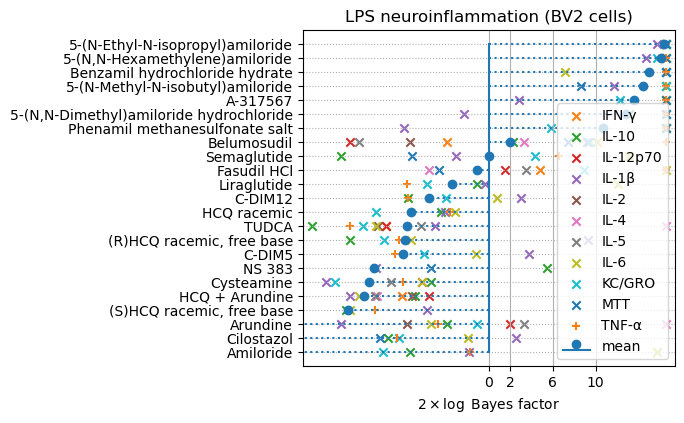

In [55]:
experiment = 'LPS neuroinflammation (BV2 cells)'
fig, ax = exper_barplot(experiment)
attila_utils.savefig(fig, 'exper-barplot-' + re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/exper-barplot-LPS-neuroinflammation-iPSC.png',
 'named-figure/exper-barplot-LPS-neuroinflammation-iPSC.pdf']

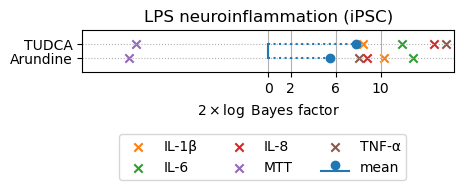

In [56]:
experiment = 'LPS neuroinflammation (iPSC)'
fig, ax = exper_barplot(experiment, draw_legend=False)
fig.legend(ncols=3, loc='upper center', bbox_to_anchor=(0.5, -0.9))
attila_utils.savefig(fig, 'exper-barplot-' + re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/exper-barplot-Trophic-factor-withdrawal-primary-neurons.png',
 'named-figure/exper-barplot-Trophic-factor-withdrawal-primary-neurons.pdf']

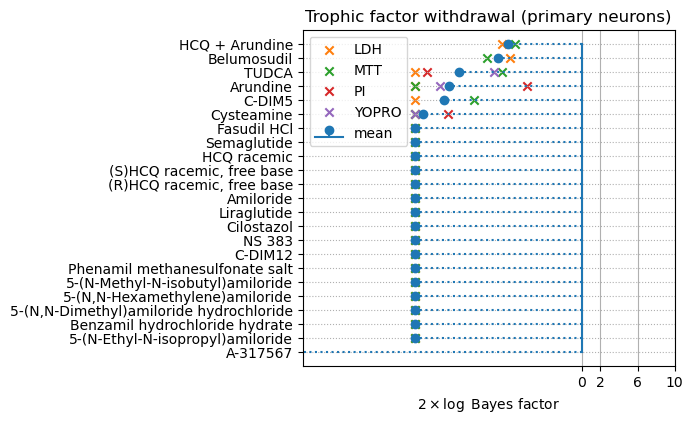

In [57]:
experiment = 'Trophic factor withdrawal (primary neurons)'
fig, ax = exper_barplot(experiment, draw_legend=True)
ax.set_xlim(-30, 10)
#fig.legend(ncols=3, loc='upper center', bbox_to_anchor=(0.5, -0.9))
attila_utils.savefig(fig, 'exper-barplot-' + re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/exper-barplot-TUDCA.png',
 'named-figure/exper-barplot-TUDCA.pdf']

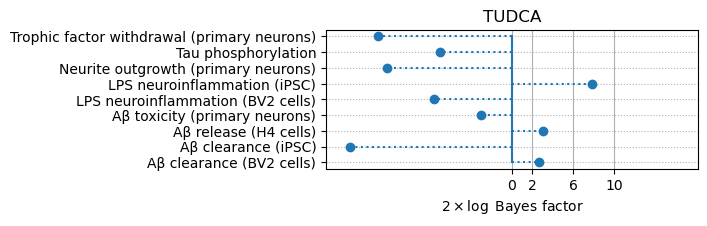

In [58]:
def drug_barplot(drug='TUDCA', BF10_agg=BF10_agg):
    s = BF10_agg.loc[drug]
    fig, ax = plt.subplots(figsize=(4.8, len(s) / 5))
    ax.stem(s, orientation='horizontal', label='mean', linefmt=':', basefmt='C0-')
    ax.set_yticks(np.arange(s.shape[0]))
    ax.set_yticklabels(s.index)
    xticks_major = [0, 2, 6, 10]
    xticks_minor = [-2, 1, 4, 8, 12]
    ax.set_xticks(xticks_major, minor=False)
    xticklabels_minor = len(xticks_minor) * ['']
    ax.grid(axis='x')
    ax.grid(axis='y', linestyle='dotted')
    lim = abs(1.1 * BF10_agg.max().max())
    ax.set_xlim(-lim, lim)
    ax.set_title(drug)
    ax.set_xlabel(r'$2 \times \log$ Bayes factor')
    return((fig, ax))

drug = 'TUDCA'
fig, ax = drug_barplot(drug)
attila_utils.savefig(fig, 'exper-barplot-' + re.sub('\W+', '-', drug).strip('-'))

drug-barplot-Valproic-acid
drug-barplot-Salbutamol
drug-barplot-Sildenafil
drug-barplot-Probenecid
drug-barplot-Montelukast
drug-barplot-Felodipine
drug-barplot-Levetiracetam
drug-barplot-Nifedipine
drug-barplot-Acitretin
drug-barplot-Dasatinib
drug-barplot-Fluticasone
drug-barplot-Methotrexate
drug-barplot-HCQ
drug-barplot-Roflumilast
drug-barplot-Napabucasin
drug-barplot-Crizotinib
drug-barplot-C188-9
drug-barplot-NAP
drug-barplot-MTS-V-50
drug-barplot-MTS-III-25
drug-barplot-TUDCA


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_57311/3419357601.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4.8, len(s) / 5))


drug-barplot-Cysteamine
drug-barplot-Rifampicin
drug-barplot-Mebendazole
drug-barplot-Pyrimethamine
drug-barplot-Arundine
drug-barplot-TUDCA-fixed-HCQ
drug-barplot-HCQ-fixed-TUDCA
drug-barplot-Amiloride
drug-barplot-Phenamil-methanesulfonate-salt
drug-barplot-Benzamil-hydrochloride-hydrate
drug-barplot-5-N-N-Dimethyl-amiloride-hydrochloride
drug-barplot-5-N-Ethyl-N-isopropyl-amiloride
drug-barplot-5-N-N-Hexamethylene-amiloride
drug-barplot-5-N-Methyl-N-isobutyl-amiloride
drug-barplot-NS-383
drug-barplot-A-317567
drug-barplot-Cilostazol
drug-barplot-C-DIM5
drug-barplot-C-DIM12
drug-barplot-Liraglutide
drug-barplot-Semaglutide
drug-barplot-HCQ-racemic
drug-barplot-S-HCQ-racemic-free-base
drug-barplot-R-HCQ-racemic-free-base
drug-barplot-HCQ-Arundine
drug-barplot-Belumosudil
drug-barplot-Fasudil-HCl


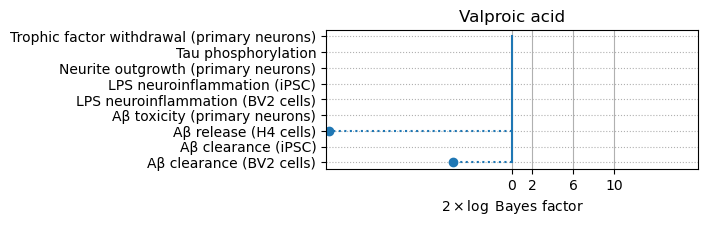

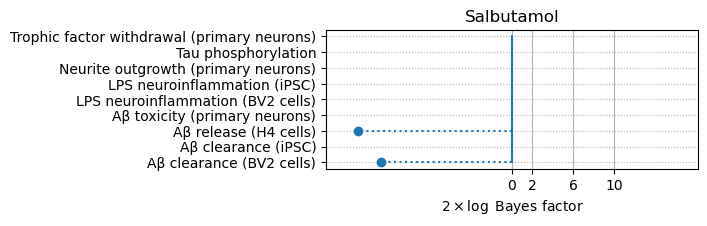

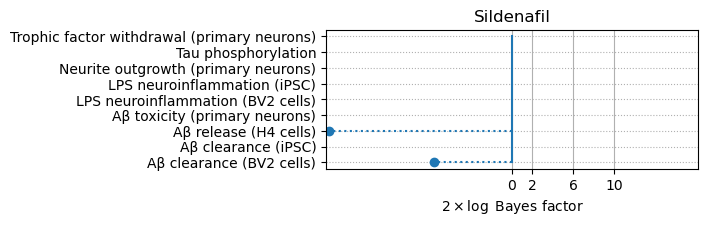

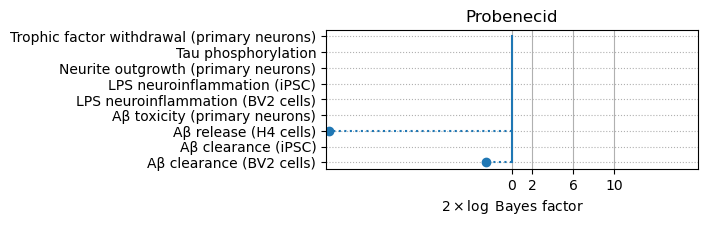

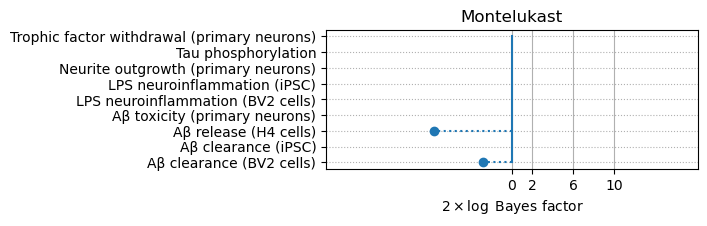

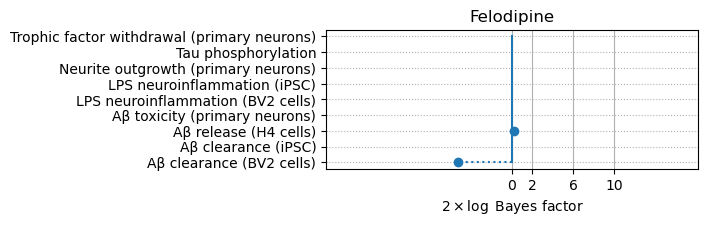

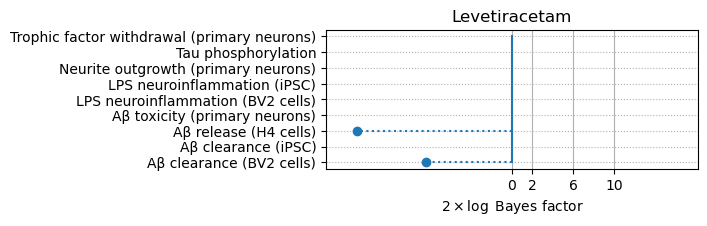

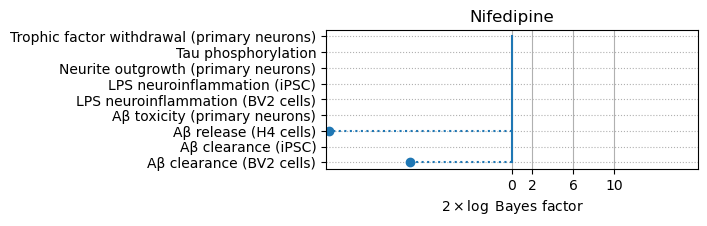

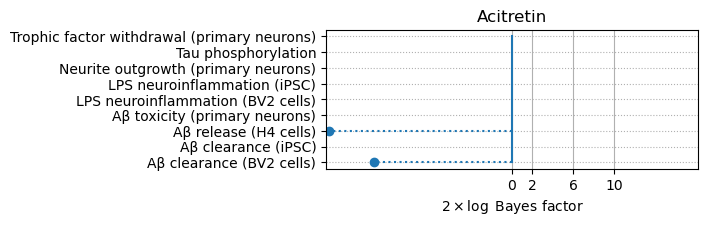

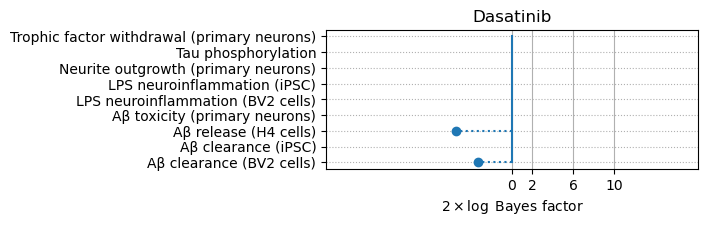

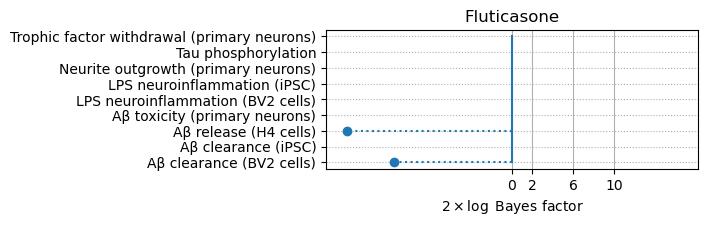

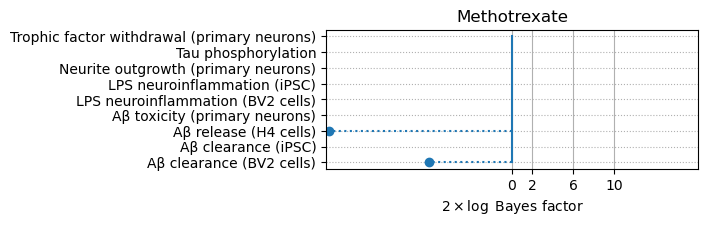

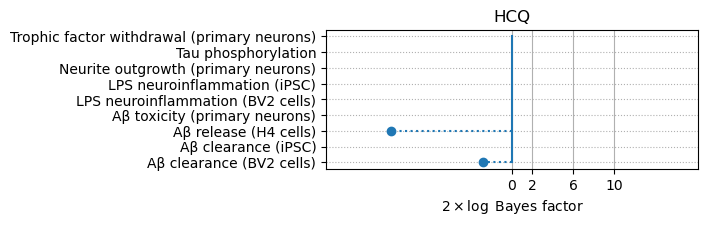

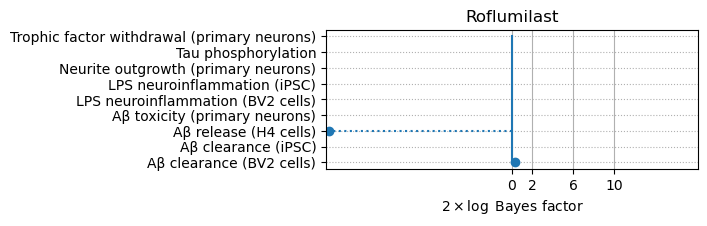

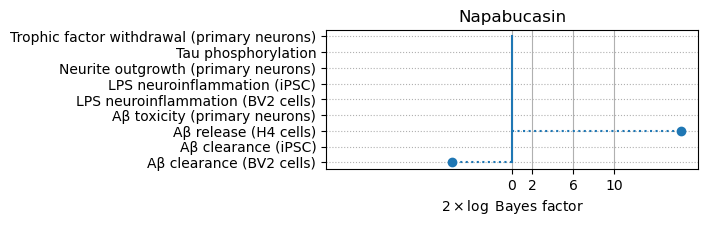

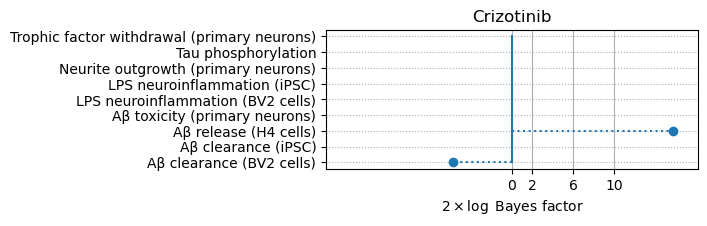

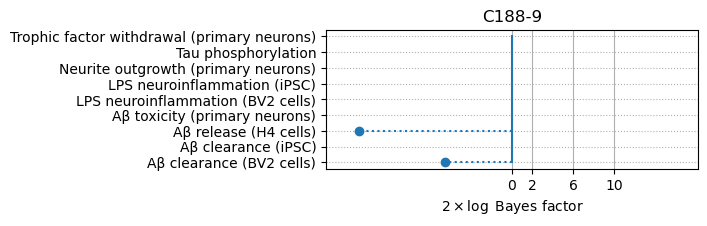

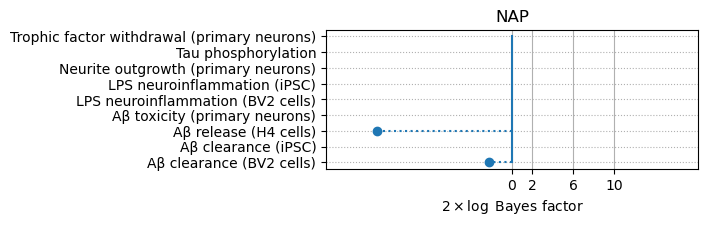

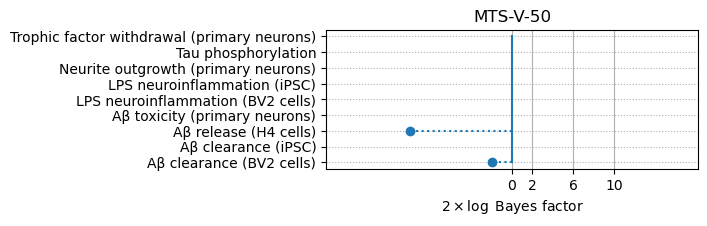

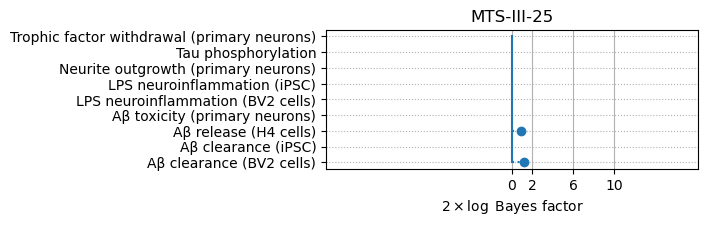

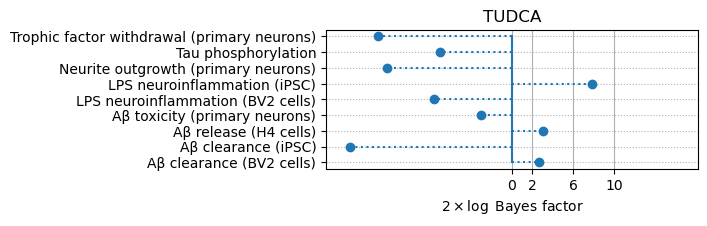

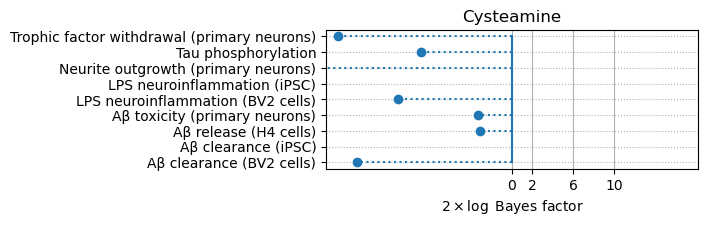

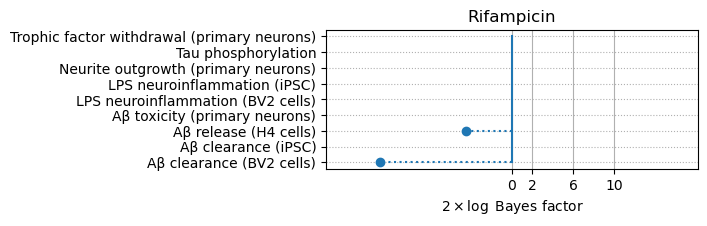

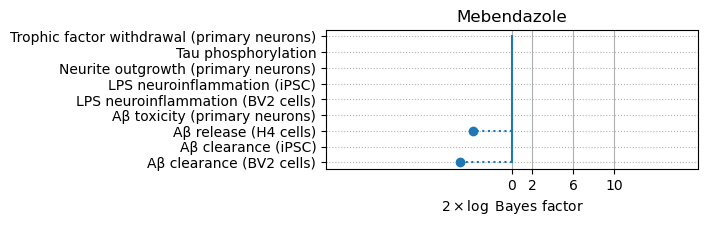

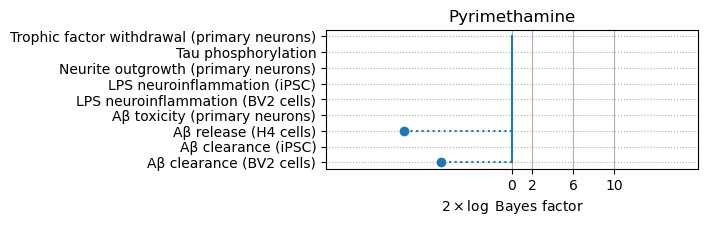

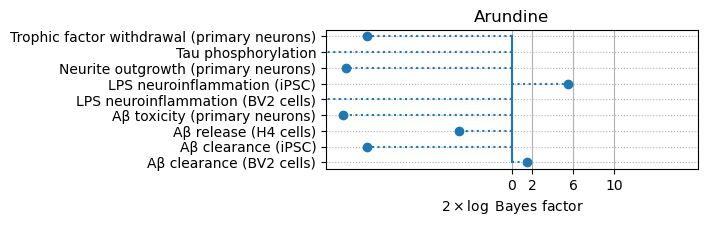

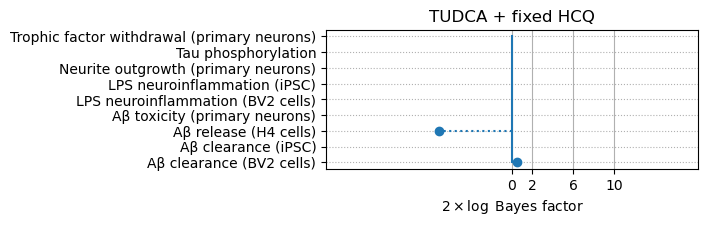

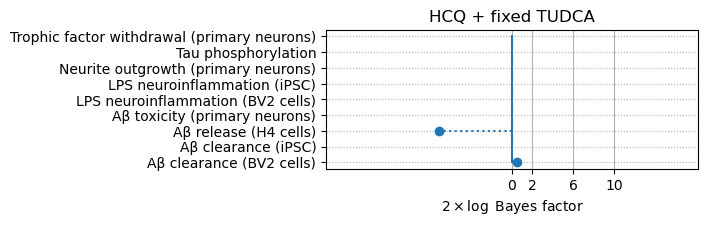

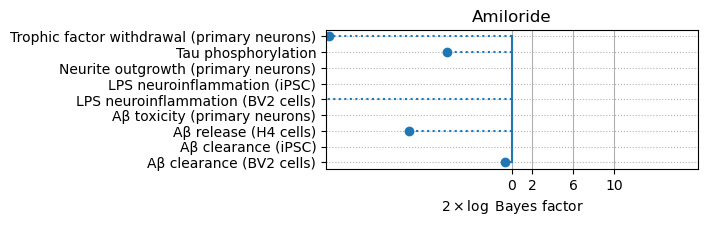

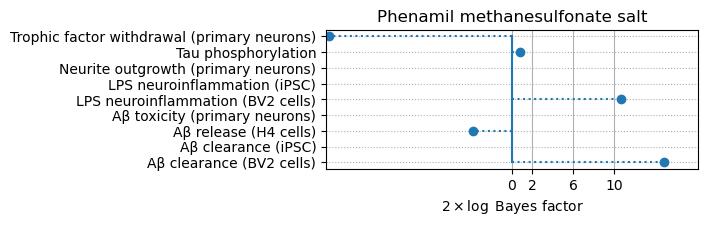

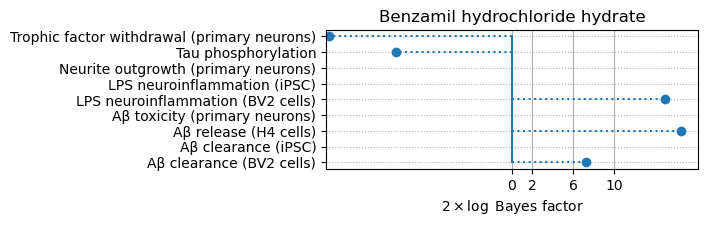

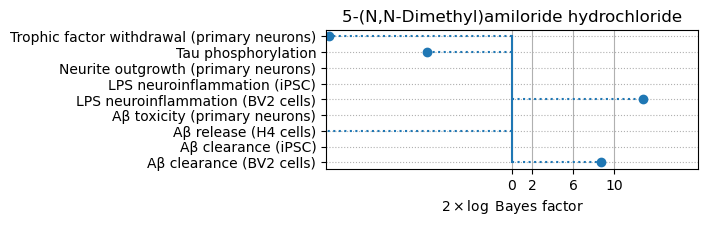

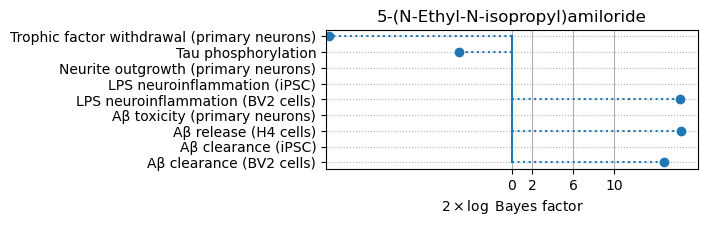

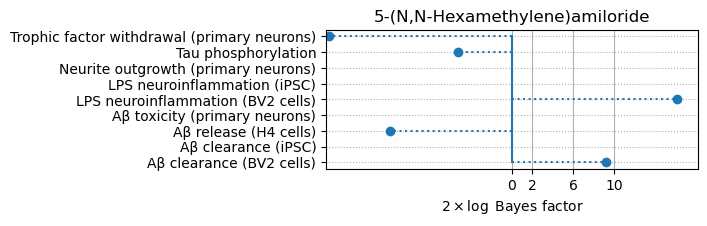

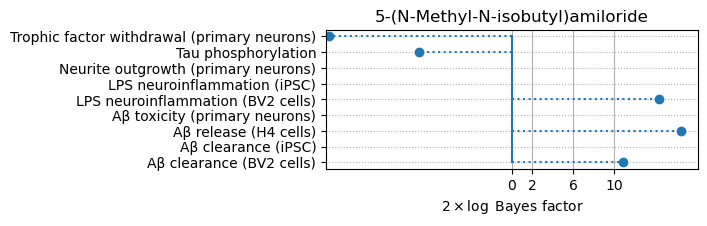

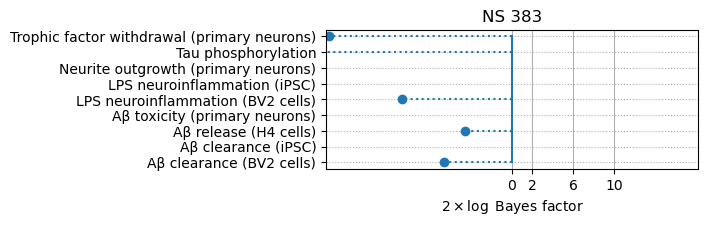

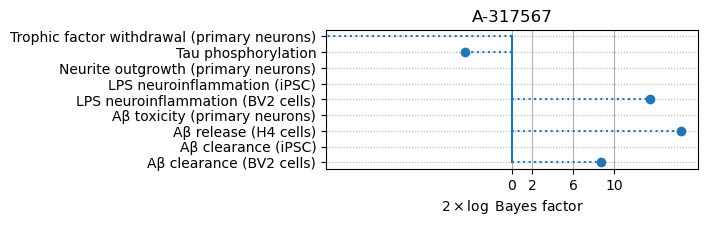

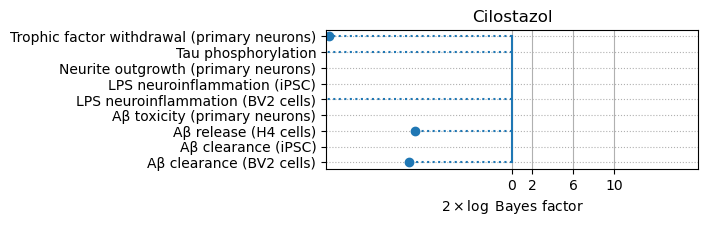

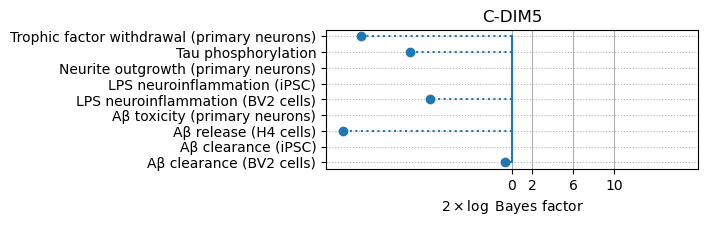

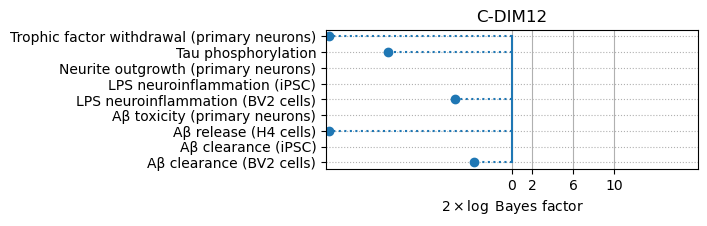

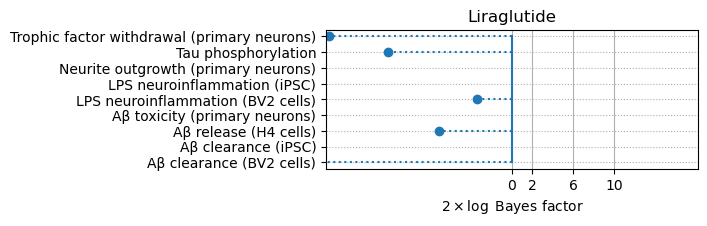

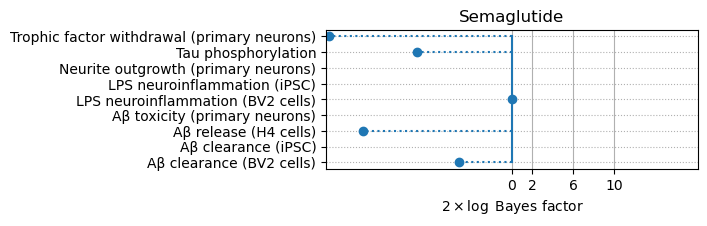

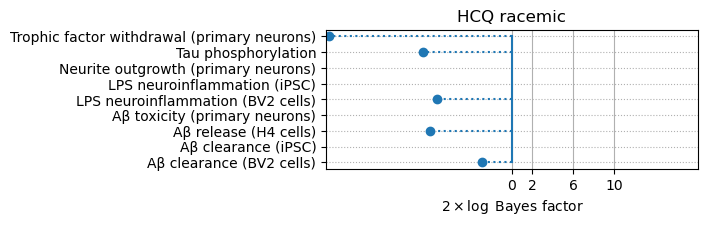

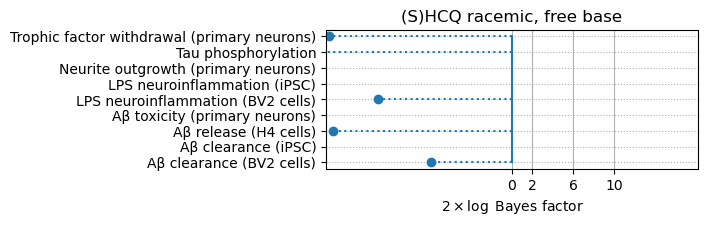

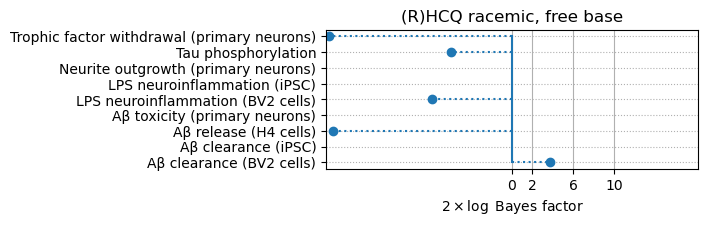

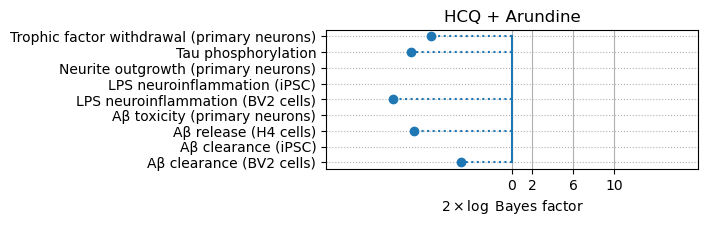

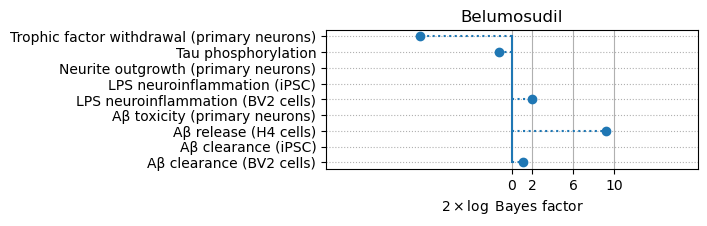

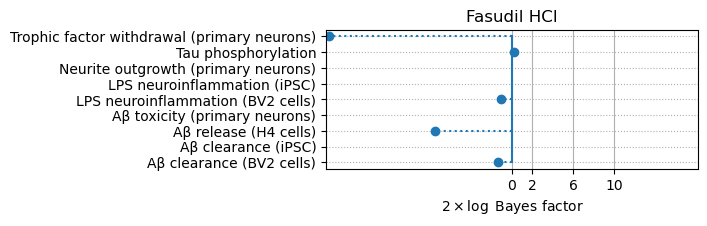

In [59]:
for drug in BF10_agg.index:
    fig, ax = drug_barplot(drug)
    bname = 'drug-barplot-' + re.sub('\W+', '-', drug).strip('-')
    attila_utils.savefig(fig, bname)
    print(bname)

MAPS coversheet

network proximity ms: remove 5xFAD and Arundine analogs

HCQ cell-based assay: check availability with Tina

In [60]:
%connect_info

{
  "shell_port": 63840,
  "iopub_port": 63841,
  "stdin_port": 63842,
  "control_port": 63844,
  "hb_port": 63843,
  "ip": "127.0.0.1",
  "key": "b98b7f27-9365066d43e559fef75b4459",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-04-09-qps-results-summary/2024-04-09-qps-results-summary.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-6cdec406-30af-46dd-8b9c-77c42b78e7db.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
